Oil Spill Classification for Major project

In [46]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [47]:
import warnings
warnings.filterwarnings("ignore")

In [48]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12,8)

In [49]:
#Dataset import
data=pd.read_csv('/content/oil_spill.csv')


In [50]:
data.head()


,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,target
0,1,2558,1506.09,456.63,90,6395000,40.88,7.89,29780.0,0.19,...,2850.00,1000.00,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,2,22325,79.11,841.03,180,55812500,51.11,1.21,61900.0,0.02,...,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,3,115,1449.85,608.43,88,287500,40.42,7.34,3340.0,0.18,...,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
3,4,1201,1562.53,295.65,66,3002500,42.40,7.97,18030.0,0.19,...,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
4,5,312,950.27,440.86,37,780000,41.43,7.03,3350.0,0.17,...,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0


In [51]:
data.duplicated().any()

False

In [52]:
data.isnull().sum().any()


False

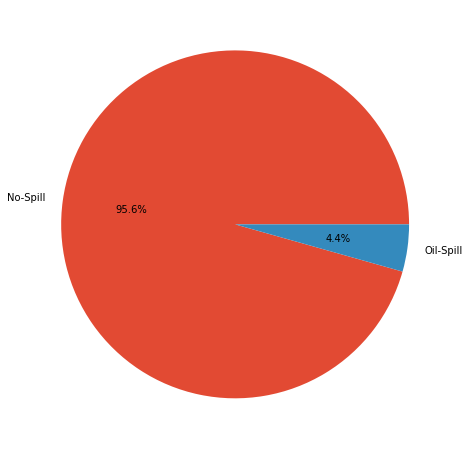

In [53]:
inter=data['target'].value_counts()
plt.pie(inter,labels=['No-Spill','Oil-Spill'],autopct='%0.1f%%',radius=1);

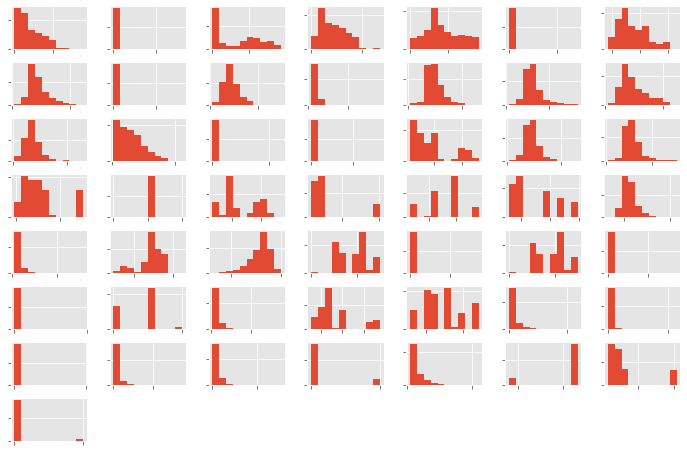

In [54]:
ax = data.hist()

for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
data.drop(['f_1','f_23'], axis=1, inplace=True)

X=data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [57]:
#importing libraries
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [58]:
#Dummy classifier
def evaluate_model(X, y, model):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(geometric_mean_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [59]:
from sklearn.dummy import DummyClassifier

In [60]:
model = DummyClassifier(strategy='uniform')
scores = evaluate_model(X_train, y_train, model)

print('Mean G-Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean G-Mean: 0.445 (0.212)


In [61]:
#importing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [62]:
#Algorithm spot checking
def get_models():
    
    models, names = list(), list()

    steps = [('t',StandardScaler()),('m',LogisticRegression(solver='liblinear'))]
    models.append(Pipeline(steps=steps))
    names.append('LR')
    
    steps = [('t', StandardScaler()),('m',LinearDiscriminantAnalysis())]
    models.append(Pipeline(steps=steps))
    names.append('LDA')
    
    models.append(GaussianNB())
    names.append('NB')
    
    models.append(RandomForestClassifier())
    names.append('RFC')
    
    models.append(XGBClassifier())
    names.append('XGB')
    
    models.append(LGBMClassifier())
    names.append('lGB')
    
    return models, names

In [63]:
models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LR 0.667 (0.257)
>LDA 0.761 (0.194)
>NB 0.779 (0.131)
>RFC 0.406 (0.296)
>XGB 0.553 (0.293)
>lGB 0.576 (0.256)


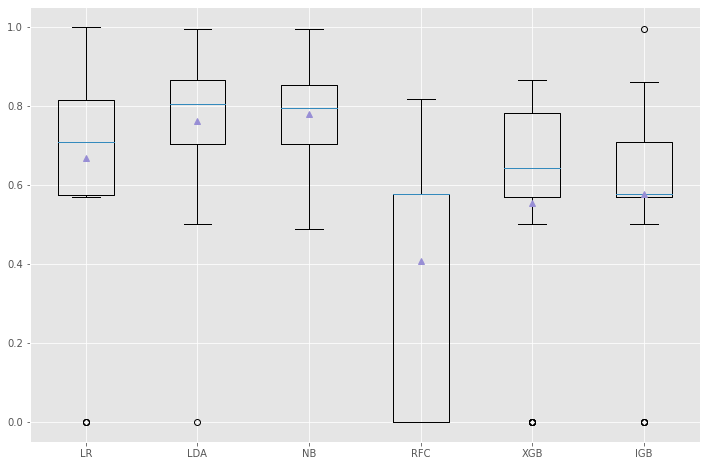

In [64]:
plt.boxplot(results, labels=names, showmeans=True);


In [65]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer


In [66]:
#Balanced Logistic Regression with standardizing techniques
def get_models():
    
    models, names = list(), list()
    
    # LR Balanced
    models.append(LogisticRegression(solver='liblinear', class_weight='balanced'))
    names.append('Balanced')
    
    # LR Balanced + Normalization
    steps = [('t',MinMaxScaler()), ('m', LogisticRegression(solver='liblinear',class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Norm')

    # LR Balanced + Standardization
    steps = [('t',StandardScaler()), ('m', LogisticRegression(solver='liblinear',class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Std')
    
    # LR Balanced + Power
    steps = [('t1',MinMaxScaler()), ('t2',PowerTransformer()), ('m',LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Power')
    
    return models, names

In [67]:
models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)
    
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>Balanced 0.863 (0.093)
>Balanced-Norm 0.833 (0.123)
>Balanced-Std 0.829 (0.132)
>Balanced-Power 0.831 (0.121)


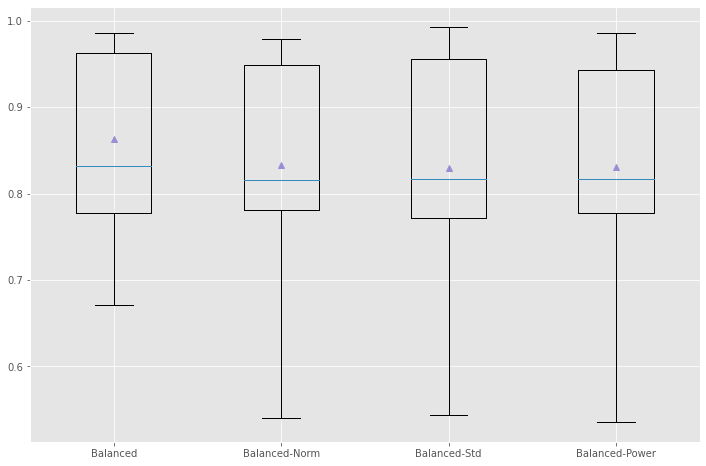

In [68]:
plt.boxplot(results, labels=names, showmeans=True);

In [69]:
#importing libraries
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

In [70]:
#Evaluate Data sampling With probablistic models  
def get_models():
    
    models, names = list(), list()

    # SMOTEENN
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('LR')

    # SMOTEENN + Norm
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t', MinMaxScaler()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('Norm')
    
    # SMOTEENN + Std
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t', StandardScaler()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('Std')

    # SMOTEENN + Power
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', sampling), ('m',
                                                                                   model)]
    models.append(Pipeline(steps=steps))
    names.append('Power')
    
    return models, names

In [71]:
models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)
    
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LR 0.838 (0.086)
>Norm 0.837 (0.115)
>Std 0.826 (0.131)
>Power 0.870 (0.100)


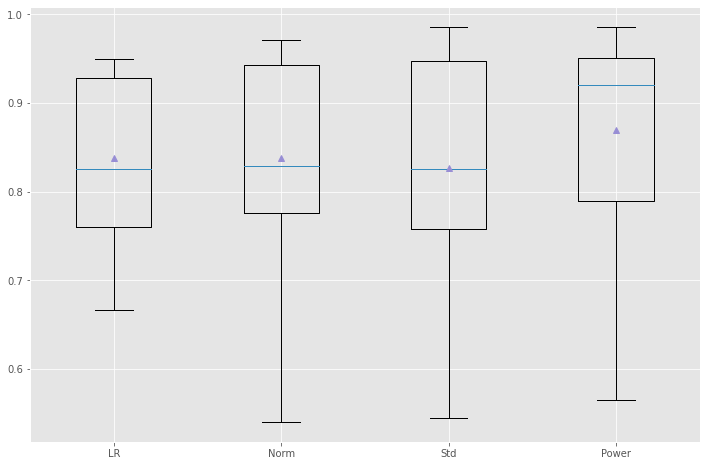

In [72]:
plt.boxplot(results, labels=names, showmeans=True);

In [73]:
#Final model
smoteenn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
model = LogisticRegression(solver='liblinear')
pipeline = Pipeline(steps=[('e', smoteenn), ('m', model)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('e',
                 SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
                ('m', LogisticRegression(solver='liblinear'))])

In [74]:
y_pred=pipeline .predict(X_test)

In [75]:
from sklearn.metrics import classification_report

In [76]:
print(f'Classification_report: \n\n {classification_report(y_test,y_pred)}')

Classification_report: 

               precision    recall  f1-score   support

           0       0.99      0.86      0.92       180
           1       0.19      0.75      0.30         8

    accuracy                           0.85       188
   macro avg       0.59      0.80      0.61       188
weighted avg       0.95      0.85      0.89       188



In [77]:
from sklearn.metrics import confusion_matrix

In [78]:
val=['No-Spill','Oil Spill']
data=pd.DataFrame(confusion_matrix(y_test,y_pred),columns=val,index=val)

Text(51.0, 0.5, 'True Label')

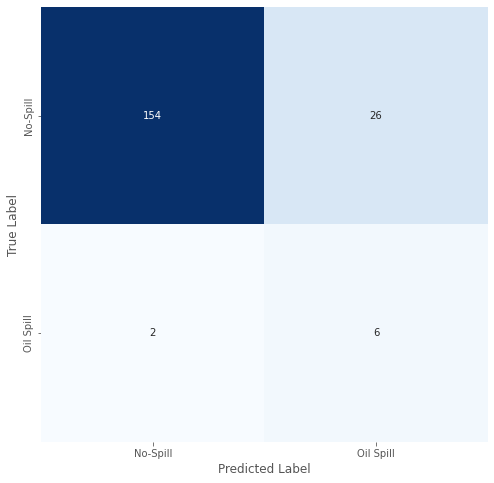

In [79]:
plt.figure(figsize=(8,8))

sns.heatmap(data,annot=True,cbar=False,cmap='Blues',fmt='g');
plt.xlabel('Predicted Label')
plt.ylabel('True Label')